In [1]:
#%tensorflow_version 2.x

In [2]:
import os
import skimage.io as io
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 0:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && unzip -q train2017.zip
    !cd data && rm -f train2017.zip

    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && unzip -q val2017.zip
    !cd data && rm -f val2017.zip
    
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip    
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        self.img_list = self.img_list[:1000]

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=18.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [16]:
INPUTE_SIZE = 256
NUM_EPOCHS = 6
BATCH_SIZE = 8

In [17]:
train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, NUM_EPOCHS, INPUTE_SIZE)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, INPUTE_SIZE)

In [18]:
train_ds

<BatchDataset shapes: ((8, 256, 256, None), (8, 256, 256, None)), types: (tf.float32, tf.float32)>

In [19]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [20]:
LEARNING_RATE = 0.0001

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

Epoch 1/6
750/750 [==============================] - 299s 391ms/step - loss: 0.5064 - accuracy: 0.7854 - val_loss: 0.5237 - val_accuracy: 0.7568
Epoch 2/6
750/750 [==============================] - 290s 387ms/step - loss: 0.4720 - accuracy: 0.7885 - val_loss: 0.5316 - val_accuracy: 0.7528
Epoch 3/6
750/750 [==============================] - 293s 390ms/step - loss: 0.4640 - accuracy: 0.7901 - val_loss: 0.5010 - val_accuracy: 0.7682
Epoch 4/6
750/750 [==============================] - 296s 395ms/step - loss: 0.4466 - accuracy: 0.7947 - val_loss: 0.4925 - val_accuracy: 0.7613
Epoch 5/6
750/750 [==============================] - 296s 395ms/step - loss: 0.4281 - accuracy: 0.8015 - val_loss: 0.4868 - val_accuracy: 0.7597
Epoch 6/6
750/750 [==============================] - 303s 405ms/step - loss: 0.4185 - accuracy: 0.8039 - val_loss: 0.4601 - val_accuracy: 0.7742
Wall time: 29min 38s


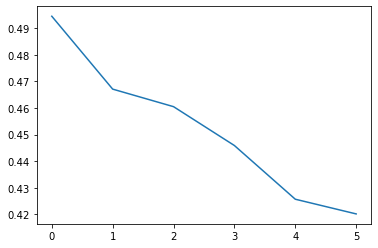

In [22]:
%%time

hist = model.fit(train_ds, 
                 #train_y, 
                 validation_data=(val_ds), 
                 callbacks=[callback],
                 batch_size=BATCH_SIZE, 
                 epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

In [23]:
model.evaluate(val_ds)

125/125 [==============================] - 18s 144ms/step - loss: 0.4601 - accuracy: 0.7742


[0.4600540101528168, 0.7741683125495911]